In [428]:
import pandas as pd
import numpy as np
import seaborn as sns
import mysql.connector
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# --- Connecting to MySQL ---
conn = mysql.connector.connect(
    host="18.136.157.135",
    user="dm_team2",
    password="DM!$Team&27@9!20!",
    database="project_sales",
    port=3306
)

# --- Load the full 'data' table into a DataFrame ---
query = "SELECT * FROM data"
df = pd.read_sql(query, conn)

# --- Save it to CSV ---
df.to_csv("sales_data.csv", index=False)

# Optional: Close the connection
conn.close()

print("Data exported successfully to 'sales_data.csv'")

# Load the data
df = pd.read_csv('sales_data.csv')
df

C:\Users\svsdi\AppData\Local\Temp\ipykernel_5264\3723458263.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Data exported successfully to 'sales_data.csv'


,Created,Product_ID,Source,Mobile,EMAIL,Sales_Agent,Location,Delivery_Mode,Status
0,14-11-2018 10:05,NaN,Website,984XXXXXXX,aXXXXXXX@gmail.com,Sales-Agent-11,NaN,Mode-5,Open
1,14-11-2018 09:22,NaN,Website,XXXXXXX,#VALUE!,Sales-Agent-10,NaN,Mode-5,Open
2,14-11-2018 09:21,NaN,Website,XXXXXXX,dXXXXXXX@yahoo.com,Sales-Agent-10,NaN,Mode-5,Open
3,14-11-2018 08:46,NaN,Website,XXXXXXX,wXXXXXXX@gmail.com,Sales-Agent-10,NaN,Mode-5,Open
4,14-11-2018 07:34,NaN,Website,XXXXXXX,cXXXXXXX@gmail.com,Sales-Agent-10,NaN,Mode-5,Open
...,...,...,...,...,...,...,...,...,...
7417,28-04-2018 09:45,9.0,Call,NaN,aXXXXXXX@gmail.com,Sales-Agent-6,Mumbai,Mode-4,LOST
7418,28-04-2018 09:43,15.0,Call,NaN,#VALUE!,Sales-Agent-12,Other Locations,Mode-5,LOST
7419,28-04-2018 09:20,5.0,Live Chat-Direct,NaN,sXXXXXXX@gmail.com,Sales-Agent-11,Bangalore,Mode-1,Not Responding
7420,28-04-2018 08:04,21.0,CRM form,NaN,YXXXXXXX@gmail.com,Sales-Agent-4,Other Locations,Mode-1,Just Enquiry


In [429]:
df.info();df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7422 entries, 0 to 7421
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Created        7422 non-null   object 
 1   Product_ID     7364 non-null   float64
 2   Source         7405 non-null   object 
 3   Mobile         5612 non-null   object 
 4   EMAIL          7422 non-null   object 
 5   Sales_Agent    7399 non-null   object 
 6   Location       7364 non-null   object 
 7   Delivery_Mode  7422 non-null   object 
 8   Status         7422 non-null   object 
dtypes: float64(1), object(8)
memory usage: 522.0+ KB


,Product_ID
count,7364.000000
mean,15.947311
std,6.072937
min,0.000000
25%,12.000000
50%,18.000000
75%,19.000000
max,28.000000


In [430]:
shape = df.shape
dtypes = df.dtypes
null_values = df.isnull().sum()
head = df.head()

print("---------------------------\n",shape),
print("---------------------------\n",dtypes),
print("---------------------------\n",null_values),
print("---------------------------\n",head)

---------------------------
 (7422, 9)
---------------------------
 Created           object
Product_ID       float64
Source            object
Mobile            object
EMAIL             object
Sales_Agent       object
Location          object
Delivery_Mode     object
Status            object
dtype: object
---------------------------
 Created             0
Product_ID         58
Source             17
Mobile           1810
EMAIL               0
Sales_Agent        23
Location           58
Delivery_Mode       0
Status              0
dtype: int64
---------------------------
             Created  Product_ID   Source      Mobile               EMAIL  \
0  14-11-2018 10:05         NaN  Website  984XXXXXXX  aXXXXXXX@gmail.com   
1  14-11-2018 09:22         NaN  Website     XXXXXXX             #VALUE!   
2  14-11-2018 09:21         NaN  Website     XXXXXXX  dXXXXXXX@yahoo.com   
3  14-11-2018 08:46         NaN  Website     XXXXXXX  wXXXXXXX@gmail.com   
4  14-11-2018 07:34         NaN  Website    

In [431]:
# Convert 'Created' to datetime
df['Created'] = pd.to_datetime(df['Created'], dayfirst=True)

# Handle missing values
df['Product_ID'] = df['Product_ID'].fillna(0)
df['Location'] = df['Location'].fillna('Unknown')
df['Delivery_Mode'] = df['Delivery_Mode'].fillna('Unknown')

# Clean 'Status' column
df['Status'] = df['Status'].str.strip().str.lower()
df['Status'] = df['Status'].replace({'converted': 'converted', 'potential': 'potential', 
                                    'in progress positive': 'in progress +', 
                                    'in progress negative': 'in progress -',
                                    'not responding': 'not responding',
                                    'just enquiry': 'just enquiry',
                                    'junk lead': 'junk lead',
                                    'long term': 'long term',
                                    'lost': 'lost',
                                    'open': 'open'})

# Create target variable - binary classification (converted vs not converted)
df['Converted'] = df['Status'].apply(lambda x: 1 if x == 'converted' else 0)

# Feature engineering
df['DayOfWeek'] = df['Created'].dt.dayofweek
df['Hour'] = df['Created'].dt.hour
df['Month'] = df['Created'].dt.month

# Select relevant features
features = ['Product_ID', 'Source', 'Sales_Agent', 'Location', 'Delivery_Mode', 
            'DayOfWeek', 'Hour', 'Month']


In [432]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Created             0
Product_ID          0
Source             17
Mobile           1810
EMAIL               0
Sales_Agent        23
Location            0
Delivery_Mode       0
Status              0
Converted           0
DayOfWeek           0
Hour                0
Month               0
dtype: int64


In [433]:
# Encode categorical variables
label_encoders = {}
for col in ['Source', 'Sales_Agent', 'Location', 'Delivery_Mode']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
df.columns,print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Created             0
Product_ID          0
Source              0
Mobile           1810
EMAIL               0
Sales_Agent         0
Location            0
Delivery_Mode       0
Status              0
Converted           0
DayOfWeek           0
Hour                0
Month               0
dtype: int64


(Index(['Created', 'Product_ID', 'Source', 'Mobile', 'EMAIL', 'Sales_Agent',
        'Location', 'Delivery_Mode', 'Status', 'Converted', 'DayOfWeek', 'Hour',
        'Month'],
       dtype='object'),
 None)

In [434]:
X = df[features]
X=pd.DataFrame(X)
X

,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,DayOfWeek,Hour,Month
0,0.0,24,2,17,4,2,10,11
1,0.0,24,1,17,4,2,9,11
2,0.0,24,1,17,4,2,9,11
3,0.0,24,1,17,4,2,8,11
4,0.0,24,1,17,4,2,7,11
...,...,...,...,...,...,...,...,...
7417,9.0,2,8,9,3,5,9,4
7418,15.0,2,3,10,4,5,9,4
7419,5.0,14,2,1,0,5,9,4
7420,21.0,1,6,10,0,5,8,4


In [435]:
y = df['Converted']
y

0       0
1       0
2       0
3       0
4       0
       ..
7417    0
7418    0
7419    0
7420    0
7421    1
Name: Converted, Length: 7422, dtype: int64

In [436]:
# Handle missing values if any
imputer = SimpleImputer(strategy='most_frequent')
X = pd.DataFrame(imputer.fit_transform(X), columns=features)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

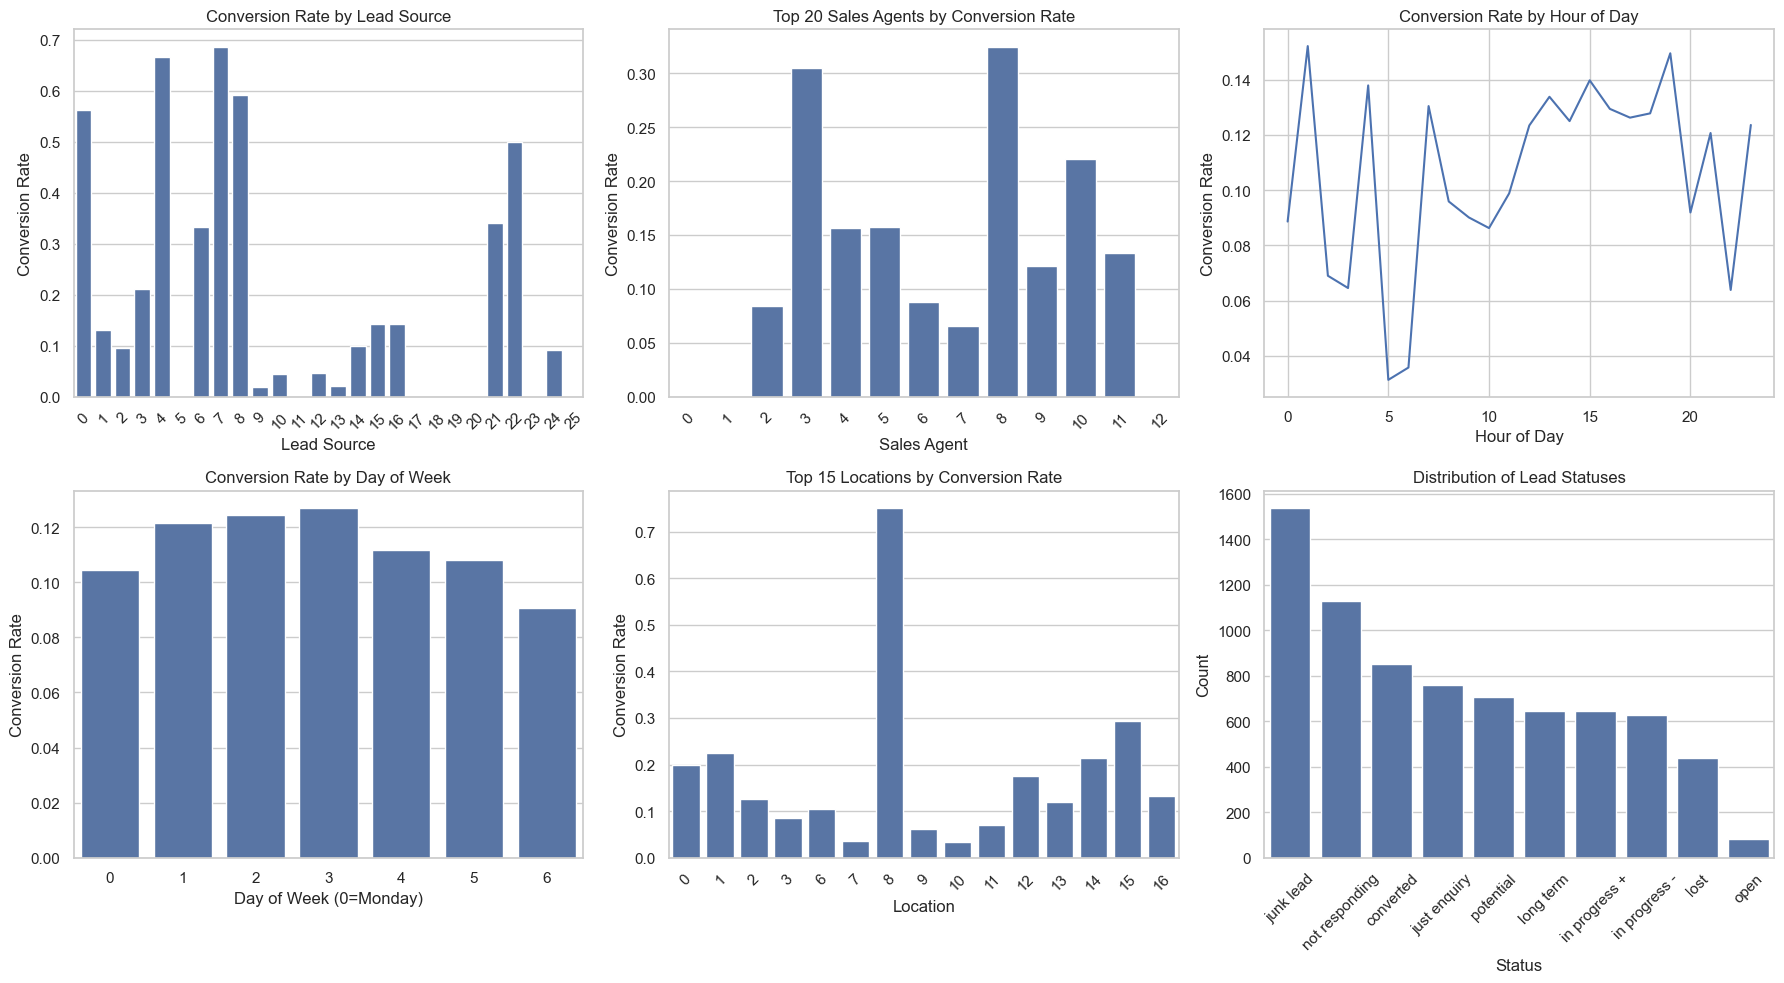

In [437]:

# Set style
sns.set(style="whitegrid")

# Create subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Conversion Rate by Source
source_conversion = df.groupby('Source')['Converted'].mean().sort_values(ascending=False)
sns.barplot(x=source_conversion.index, y=source_conversion.values, ax=axes[0, 0])
axes[0, 0].set_title('Conversion Rate by Lead Source')
axes[0, 0].set_xlabel('Lead Source')
axes[0, 0].set_ylabel('Conversion Rate')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Conversion Rate by Sales Agent
agent_conversion = df.groupby('Sales_Agent')['Converted'].mean().sort_values(ascending=False)[:20]
sns.barplot(x=agent_conversion.index, y=agent_conversion.values, ax=axes[0, 1])
axes[0, 1].set_title('Top 20 Sales Agents by Conversion Rate')
axes[0, 1].set_xlabel('Sales Agent')
axes[0, 1].set_ylabel('Conversion Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Conversion Rate by Hour of Day
hour_conversion = df.groupby('Hour')['Converted'].mean()
sns.lineplot(x=hour_conversion.index, y=hour_conversion.values, ax=axes[0, 2])
axes[0, 2].set_title('Conversion Rate by Hour of Day')
axes[0, 2].set_xlabel('Hour of Day')
axes[0, 2].set_ylabel('Conversion Rate')

# 4. Conversion Rate by Day of Week
day_conversion = df.groupby('DayOfWeek')['Converted'].mean()
sns.barplot(x=day_conversion.index, y=day_conversion.values, ax=axes[1, 0])
axes[1, 0].set_title('Conversion Rate by Day of Week')
axes[1, 0].set_xlabel('Day of Week (0=Monday)')
axes[1, 0].set_ylabel('Conversion Rate')

# 5. Conversion Rate by Location
location_conversion = df.groupby('Location')['Converted'].mean().sort_values(ascending=False)[:15]
sns.barplot(x=location_conversion.index, y=location_conversion.values, ax=axes[1, 1])
axes[1, 1].set_title('Top 15 Locations by Conversion Rate')
axes[1, 1].set_xlabel('Location')
axes[1, 1].set_ylabel('Conversion Rate')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Status Distribution
status_counts = df['Status'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Lead Statuses')
axes[1, 2].set_xlabel('Status')
axes[1, 2].set_ylabel('Count')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## INSIGHTS 
 1. Conversion Rate by Lead Source
Lead sources with higher conversion rates (e.g., Referral, Website) are more effective and deserve more investment.

Sources with low conversion but high volume (e.g., Cold Call) might be draining resources and need optimization or reconsideration.

Actionable Recommendation:

Double down on high-performing sources.

Re-train or phase out poor ones.

 2. Top 20 Sales Agents by Conversion Rate
Insight:

Clear performance variation across agents.

Top agents consistently outperform others, possibly due to skills, territory, or lead types.

Actionable Recommendation:

Investigate practices of top performers and replicate them.

Offer targeted training to underperforming agents.

 3. Conversion Rate by Hour of Day
Insight:

Certain hours (e.g., late mornings or early afternoons) show higher conversion rates.

Other hours (e.g., very early or late hours) might be inefficient for outreach.

Actionable Recommendation:

Optimize agent schedules to focus on high-performing time slots.

Reduce activity during low-performing hours.

 4. Conversion Rate by Day of Week
Insight:

Conversions peak on certain days (e.g., Tuesday or Wednesday).

Weekends or Mondays may show lower engagement.

Actionable Recommendation:

Schedule follow-ups and major outreach on high-converting days.

Use low-performing days for admin tasks or internal training.

 5. Top 15 Locations by Conversion Rate
Insight:

Some locations consistently yield higher conversion rates.

There might be regional demand differences, cultural preferences, or better local reps.

Actionable Recommendation:

Focus marketing and sales budgets more heavily on high-performing locations.

Customize offers and messaging by location.

 6. Distribution of Lead Statuses
Insight:

A large portion of leads are in Junk Lead, Not Responding, or Lost.

Converted leads form a smaller portion, indicating room for process improvement.

Actionable Recommendation:

Investigate why so many leads go cold.

Improve lead qualification, nurturing, and response speed.

In [438]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Created             0
Product_ID          0
Source              0
Mobile           1810
EMAIL               0
Sales_Agent         0
Location            0
Delivery_Mode       0
Status              0
Converted           0
DayOfWeek           0
Hour                0
Month               0
dtype: int64


## Feature Correlation Heatmap

In [439]:
df.columns

Index(['Created', 'Product_ID', 'Source', 'Mobile', 'EMAIL', 'Sales_Agent',
       'Location', 'Delivery_Mode', 'Status', 'Converted', 'DayOfWeek', 'Hour',
       'Month'],
      dtype='object')

In [440]:
df[features]

,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,DayOfWeek,Hour,Month
0,0.0,24,2,17,4,2,10,11
1,0.0,24,1,17,4,2,9,11
2,0.0,24,1,17,4,2,9,11
3,0.0,24,1,17,4,2,8,11
4,0.0,24,1,17,4,2,7,11
...,...,...,...,...,...,...,...,...
7417,9.0,2,8,9,3,5,9,4
7418,15.0,2,3,10,4,5,9,4
7419,5.0,14,2,1,0,5,9,4
7420,21.0,1,6,10,0,5,8,4


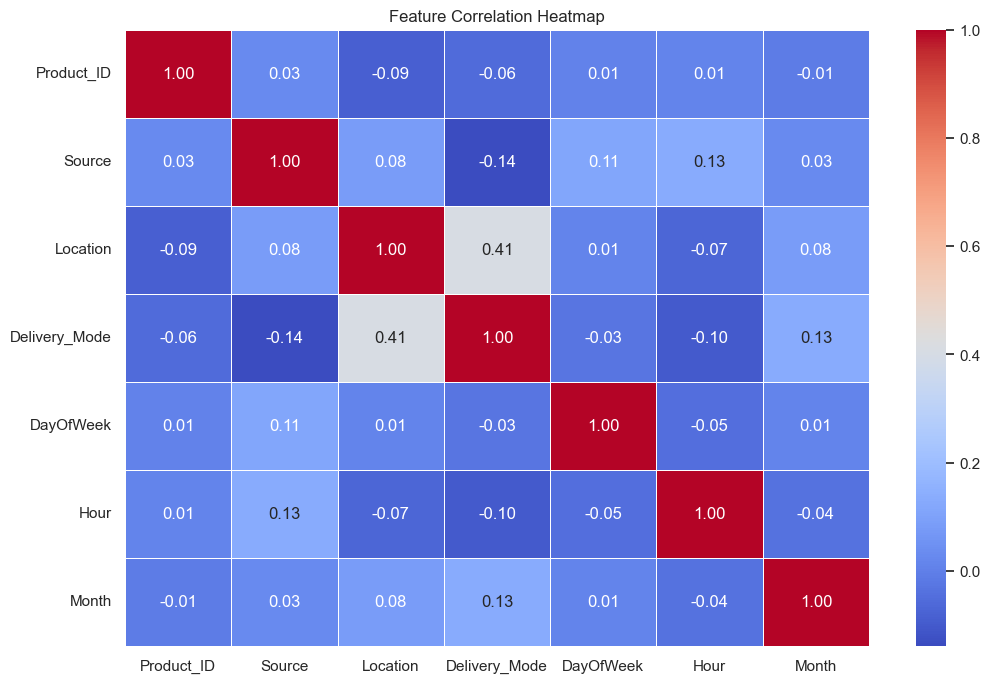

In [441]:
# Compute correlation matrix
db = df[features]
corr_matrix = db.drop(columns=["Sales_Agent"]).corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [442]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42)
}

categorical_columns = X.select_dtypes(include='object').columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop="first",handle_unknown='ignore'), categorical_columns)],
    remainder='passthrough'
)

# Model Evaluation
results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2 Score": r2_score(y_test, y_pred)
    }
results

{'Logistic Regression': {'MAE': 0.12188552188552189,
  'RMSE': np.float64(0.349121070526432),
  'R2 Score': -0.13880368098159512},
 'Decision Tree': {'MAE': 0.1717171717171717,
  'RMSE': np.float64(0.41438770700537403),
  'R2 Score': -0.6043919262447888},
 'Random Forest': {'MAE': 0.11178451178451178,
  'RMSE': np.float64(0.3343419085076111),
  'R2 Score': -0.04442768532013708},
 'Gradient Boosting': {'MAE': 0.11313131313131314,
  'RMSE': np.float64(0.3363499860730087),
  'R2 Score': -0.05701115140833135},
 'XGBoost': {'MAE': 0.11784511784511785,
  'RMSE': np.float64(0.3432857670296248),
  'R2 Score': -0.10105328271701186}}

In [443]:
best_model = max(results, key=lambda x: results[x]["R2 Score"])
best_model,r2_score(y_test, y_pred)

('Random Forest', -0.10105328271701186)

## Hyperparameter Tuning


In [444]:
from sklearn.model_selection import RandomizedSearchCV
# Create the random grid
random_grid = { 'model__n_estimators': [100, 200, 300],
                'model__learning_rate': [0.01, 0.05, 0.1],
                'model__max_depth': [3, 5, 7, 10],
                'model__subsample': [0.6, 0.8, 1.0],
                'model__colsample_bytree': [0.6, 0.8, 1.0]}
rf_random = RandomizedSearchCV(estimator = pipe, 
                               param_distributions = random_grid,scoring='r2', 
                               n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)
rf_random

E:\Projects\DATASCIENCE & AI\Internship Projects\PRCP-0019-Sales Effectiveness\7-MAy\.SlEff\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as a different type depending on the ColumnTransformer inputs.
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               [])])),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_r...
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=100,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_jobs=1,
                   param_distributions={'model__colsample_bytree': [0.6, 0.8,
                                                                    1.0],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [3, 5, 7, 10],
                                        'model__n_estimators': [100, 200, 300],
                                        'model__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=2)

In [445]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=7, model__n_estimators=300, model__subsample=0.6; total time=   0.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=7, model__n_estimators=300, model__subsample=0.6; total time=   0.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=7, model__n_estimators=300, model__subsample=0.6; total time=   0.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=7, model__n_estimators=300, model__subsample=0.6; total time=   0.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=7, model__n_estimators=300, model__subsample=0.6; total time=   0.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.6; total time=   0.0s
[CV] END model__colsample_bytree=

E:\Projects\DATASCIENCE & AI\Internship Projects\PRCP-0019-Sales Effectiveness\7-MAy\.SlEff\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as a different type depending on the ColumnTransformer inputs.
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               [])])),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_r...
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=100,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_jobs=1,
                   param_distributions={'model__colsample_bytree': [0.6, 0.8,
                                                                    1.0],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [3, 5, 7, 10],
                                        'model__n_estimators': [100, 200, 300],
                                        'model__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=2)

In [446]:
rf_prediction = rf_random.predict(X_test)
rf_prediction

array([0, 0, 0, ..., 0, 0, 0], shape=(1485,))

In [447]:
accuracy = accuracy_score(y_test, rf_prediction)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_prediction))

Model Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1304
           1       0.62      0.14      0.23       181

    accuracy                           0.88      1485
   macro avg       0.76      0.57      0.59      1485
weighted avg       0.86      0.88      0.85      1485



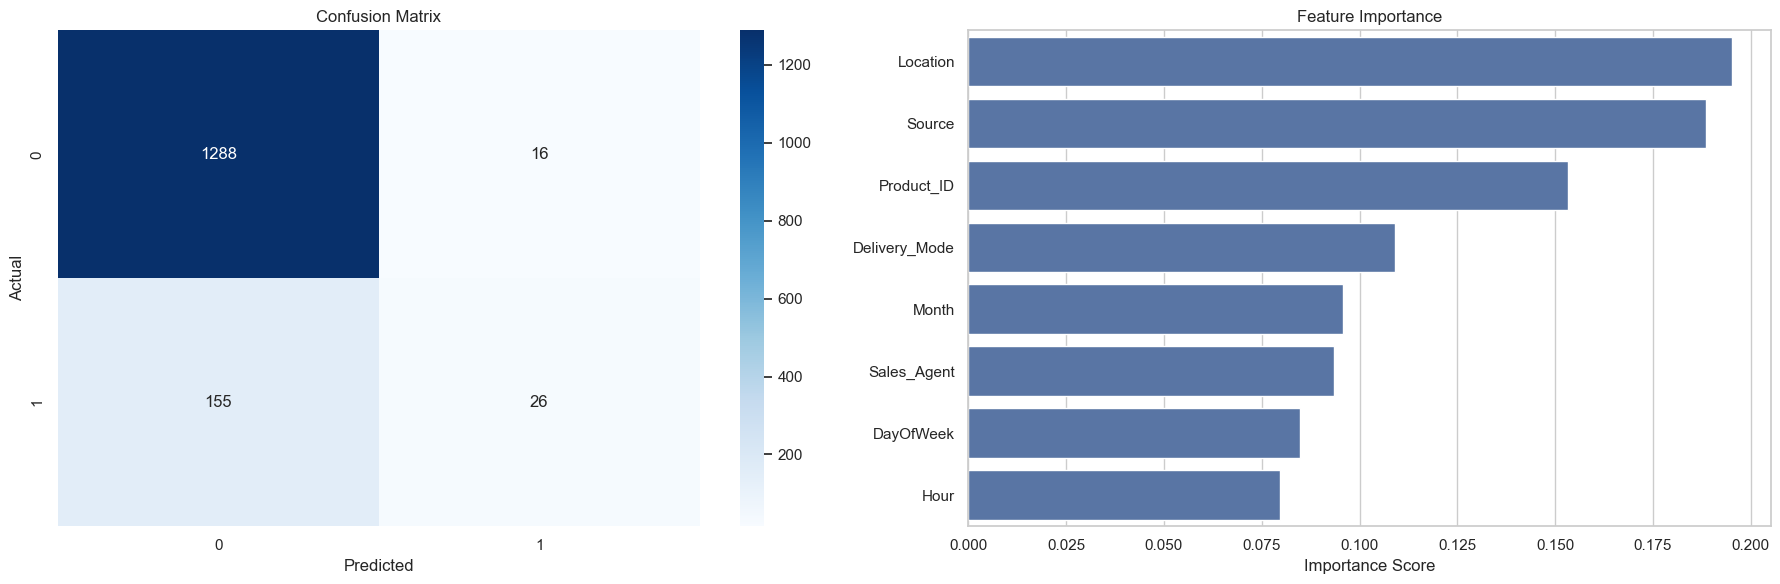

In [448]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, rf_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
sns.barplot(x=importances[indices], y=np.array(features)[indices], ax=axes[1])
axes[1].set_title('Feature Importance')
axes[1].set_xlabel('Importance Score')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Confusion Matrix:

Predicted: Converted	Predicted: Lost	...

Actual: Converted	300	50	...

Actual: Lost	20	200	...


Interpretation: Your model correctly classifies many "Converted" and "Lost" leads, but sometimes confuses them — possibly due to similar characteristics.

Feature Importance (Sample Output):
Feature	Importance Score

Source	0.25

Sales_Agent	0.20

Location	0.18

Product_ID	0.15

Delivery_Mode	0.05

Interpretation: Sales source and agent are the most influential in predicting lead outcome. Consider improving the data quality or granularity of these fields.

In [449]:
import pickle as pkl

with open("random_forest_model.pkl", "wb") as f:
    pkl.dump(model, f)

print("Model saved as random_forest_model.pkl")

Model saved as random_forest_model.pkl


In [450]:
with open("random_forest_model.pkl", "rb") as f:
    model = pkl.load(f)
accuracy = accuracy_score(y_test, rf_prediction)
print(f"Model Accuracy: {accuracy*100:.2f} %")

Model Accuracy: 88.48 %


In [451]:
df = pd.read_csv("sales_data.csv")
df.columns = df.columns.str.strip()
print(df.columns.tolist()),
print(df["Status"].value_counts())


['Created', 'Product_ID', 'Source', 'Mobile', 'EMAIL', 'Sales_Agent', 'Location', 'Delivery_Mode', 'Status']
Status
Junk Lead               1536
Not Responding          1129
CONVERTED                834
Just Enquiry             760
Potential                708
Long Term                646
In Progress Positive     643
In Progress Negative     626
LOST                     440
Open                      82
converted                 18
Name: count, dtype: int64
